# Wstępna analiza

Zbiór danych house.csv zawiera ceny oraz paramatery domów w nieokreślonej lokalizacji w latach 2014-2015. Celem zadania, jest posiadając powyższe dane przewidzieć w jak najdokładnieszy sposób czy dany dom jest warty milion i więcej, czy też nie. Problem ten, jest problemem klasyfikacji, dlatego też wykorzystane muszą zostać przeznaczone do tego algorytmy.

# Wczytanie bibliotek oraz danych

Wczytanie bibliotek.

In [1]:
import numpy as np 
import pandas as pd 
import time
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=UserWarning)

Wczytanie danych.

In [2]:
X_all_data = pd.read_csv(r'C:\Users\macio\Documents\Python\Data Science\Addepto_House_Pricing\house.csv', index_col='id')
X_all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21613 entries, 7129300520 to 1523300157
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21613 non-null  object 
 1   price          21613 non-null  float64
 2   price_bin      21613 non-null  int64  
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float

# Podział oraz wizualizacja danych

Sprawdzenie czy są jakieś brakujące wartości.

In [3]:
X_all_data.isnull().sum()

date             0
price            0
price_bin        0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

Podzielnie danych na x i y.

In [4]:
y_all_data = X_all_data.price_bin
X_all_data.drop(['price', 'price_bin'], axis=1, inplace=True)
X_all_data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,
7129300520,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6414100192,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
5631500400,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2487200875,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1954400510,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Sprawdzenie czy zbiór danych jest zbalansowany, czy nie. 

In [5]:
y_all_data.value_counts()

0    20148
1     1465
Name: price_bin, dtype: int64

Konwersja formatu daty.

In [6]:
X_all_data['date'] = pd.to_datetime(X_all_data['date'])
X_all_data['month'] = X_all_data['date'].apply(lambda date:date.month)
X_all_data['year'] = X_all_data['date'].apply(lambda date:date.year)
X_all_data.drop(['date'], axis=1, inplace=True)

Podzielenie danych na zbiór treningowy/walidacyjny oraz na testowy (85%/15%).

Walidacja modeli będzie się odbywała za pomocą walidacji krzyżowej.

In [7]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X_all_data, y_all_data, train_size=0.85, test_size=0.15, random_state=1)

Rozkład wartości w poszczególnych kolumnach.

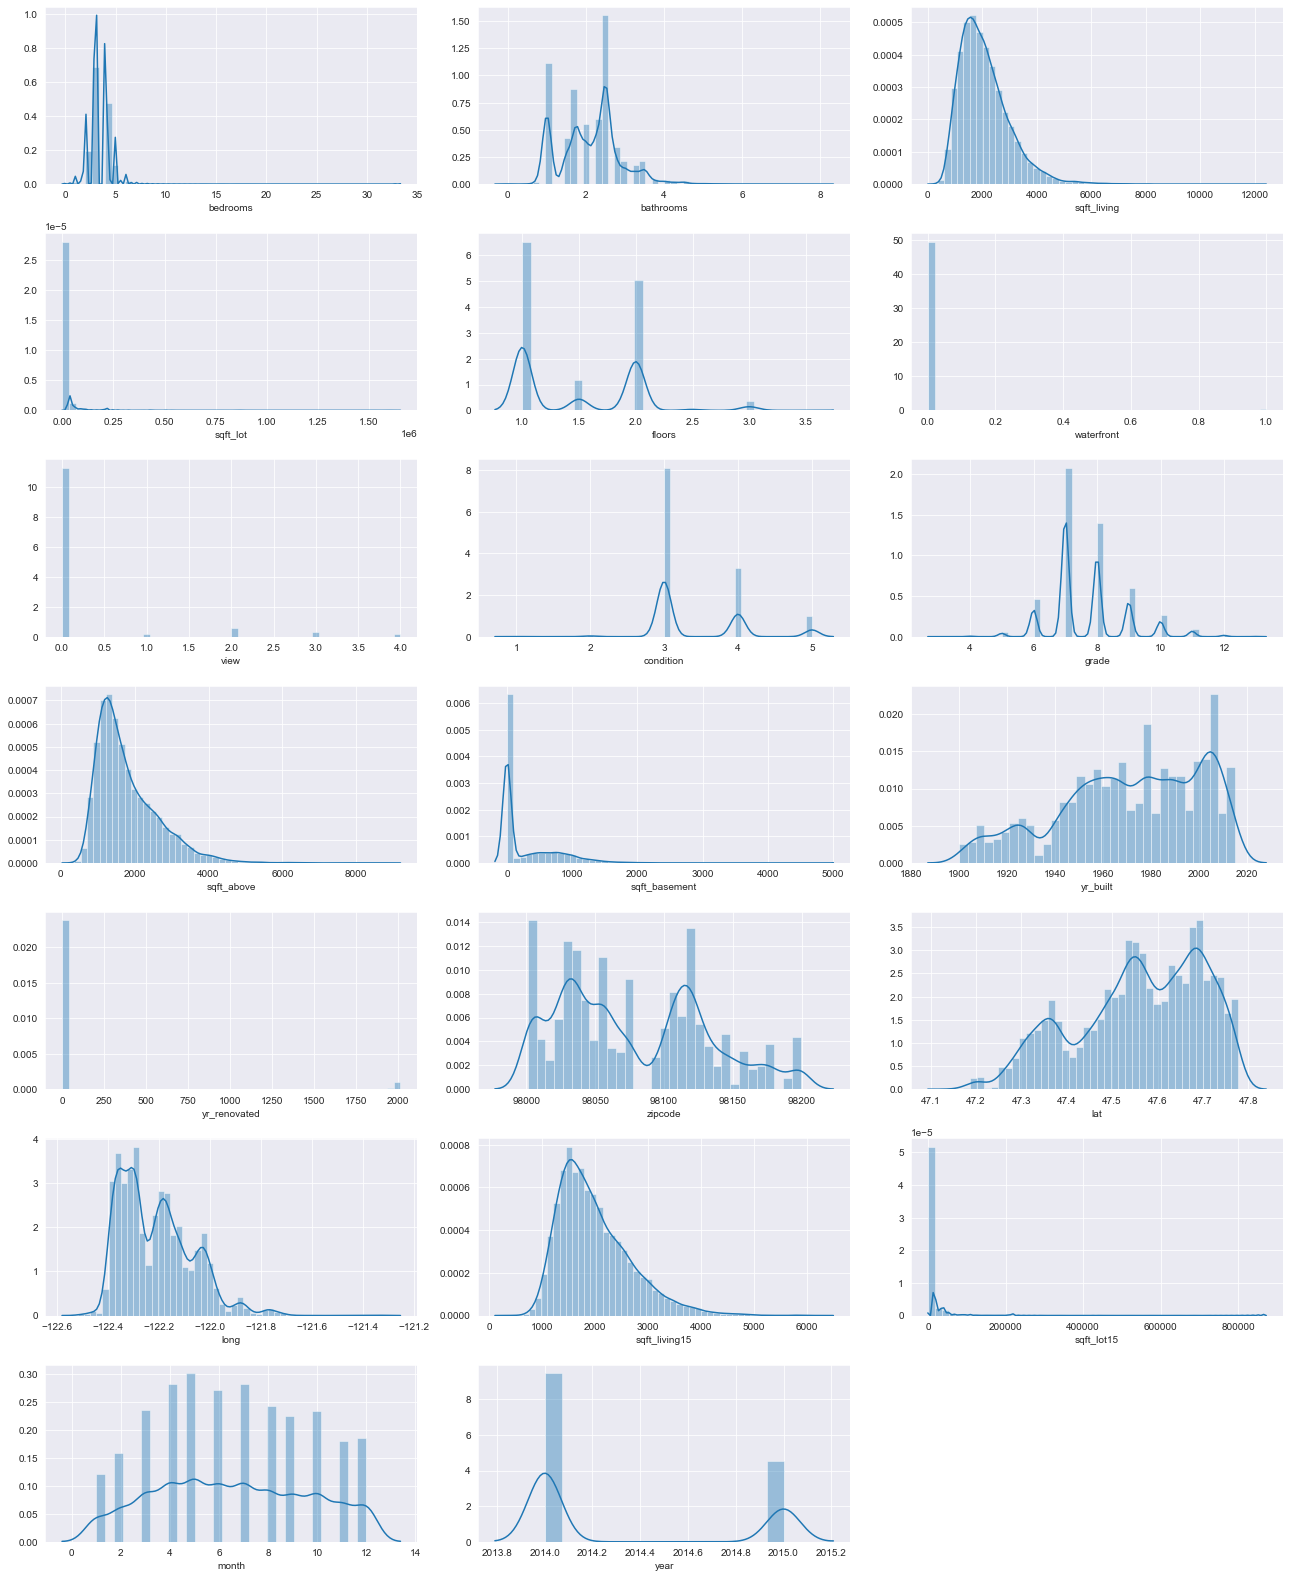

In [8]:
fig = plt.figure(figsize=(18,22))
for index in range(len(X_train_valid.columns)):
    plt.subplot(7,3,index+1)
    sns.distplot(X_train_valid.iloc[:,index].dropna(), norm_hist=False)
fig.tight_layout(pad=1.0)

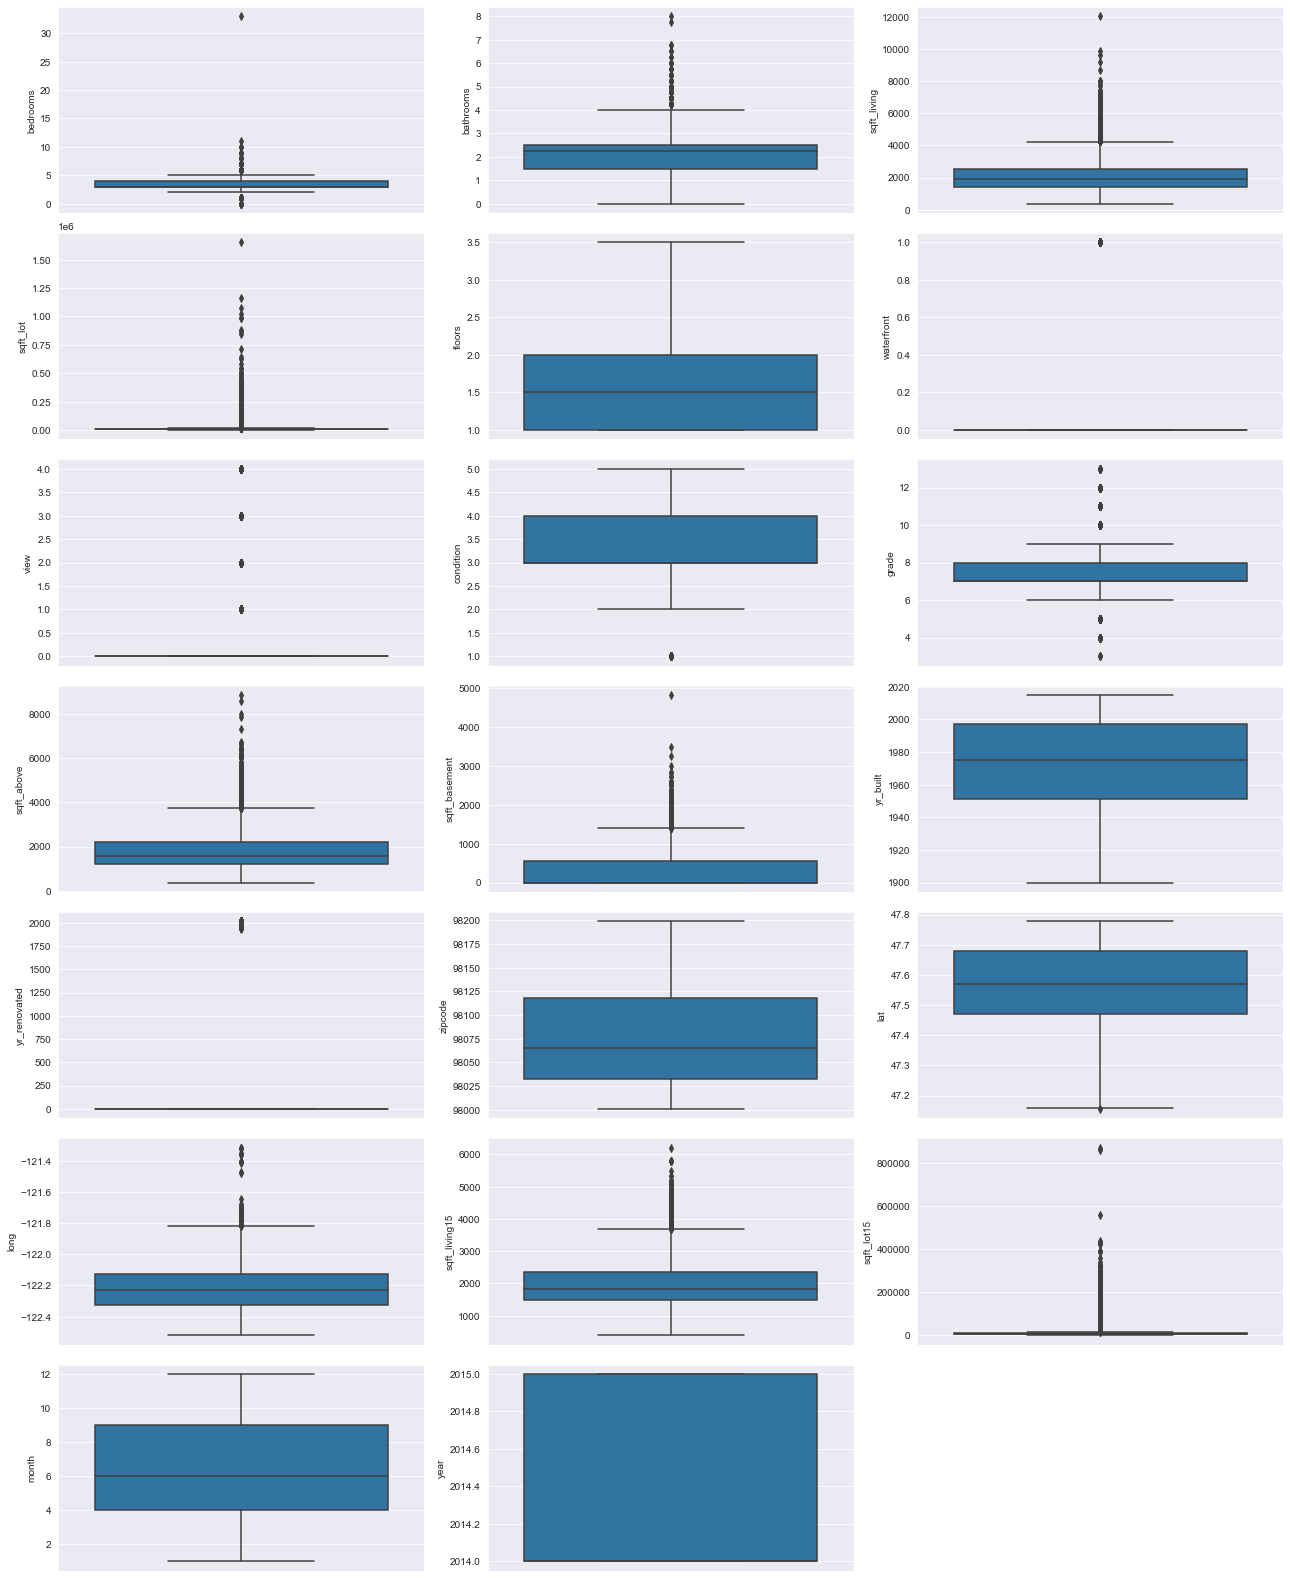

In [9]:
fig = plt.figure(figsize=(18,22))
for index in range(len(X_train_valid.columns)):
    plt.subplot(7,3,index+1)
    sns.boxplot(y=X_train_valid.iloc[:,index], data=X_train_valid.dropna())
fig.tight_layout(pad=1.0)

Odrzucenie prawdopodobnie błędnych danych w postaci domów bez łazienek.

In [10]:
zero_bathrooms = X_train_valid.index[X_train_valid['bathrooms'] == 0]
X_train_valid.drop(zero_bathrooms)
print('Liczba domów bez łazienek: ', len(zero_bathrooms))

Liczba domów bez łazienek:  7


Odrzucenie prawdopodobnie błędnych danych w postaci domu o 33 sypialniach.

In [11]:
thirty_three_bedrooms = X_train_valid.index[X_train_valid['bedrooms'] > 30]
X_train_valid.drop(thirty_three_bedrooms)
X_train_valid.loc[thirty_three_bedrooms]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,year
id,,,,,,,,,,,,,,,,,,,,
2402100895,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700,6,2014


Sprawdzenie ile unikalnych wartości znajduje się w kolumnie 'waterfront'.

In [69]:
print(X_train_valid['waterfront'].nunique()) 

2


# Preprocesing danych

Zastosowanie algorytmu SMOTE do nadpróbkowania niezbalansowanego zestawu danych. Poniżej znajdują się jego parametry, natomiast dla każdej z walidacji krzyżowej algorytm wykonywany jest osobno.

In [70]:
sm = SMOTE(sampling_strategy = 0.2, n_jobs=-1, random_state = 1)

Wykorzystanie RobustScaler do zredukowania wpływu wartości skrajnych cech.

# Modele do klasyfikacji

Zdecydowałem się zasosować następujące modele w problemie klasyfikacji ceny domów:

* LightGBMRegressor
* KNN
* Support Vector Classifier
* RandomForestClassifer

Dla każdego z modeli przeprowadzona została podstawowa opytmalizacja hiperparametrów(GridSearchCV/RandomizedSearchCV). Modele są poddawane 5-krotnej walidacji krzyżowej, a najlepsze parametry dobierane są na podstawie F1 score. Zastosowano pipeline, aby podczas walidacji krzyżowej algorytm SMOTE wykonywany był osobno i nie dotyczył zbioru walidayjnego.

Funkcja przedstawiająca wyniki 5-krotnej walidacji modelu.

In [71]:
def evaluate_model(model, name):
    model_performances = pd.DataFrame({
        'Model' : [name],
        'Mean F1 score(val)' : round(model.cv_results_['mean_test_f1'][model.best_index_], 3),
        'Mean Precision(val)': round(model.cv_results_['mean_test_precision'][model.best_index_], 3),
        'Mean Recall(val)': round(model.cv_results_['mean_test_recall'][model.best_index_], 3),
        'Fit time(val)': round(model.cv_results_['mean_fit_time'][model.best_index_], 3)
    })
    model_performances.set_index('Model', inplace=True, drop=True)
    return model_performances

In [72]:
kf = StratifiedKFold(5, shuffle=True, random_state=1)

Model LightGBM.

In [94]:
start = time.time()

lgbm = Pipeline([
        ('sampling', sm),
        ('scaling', RobustScaler()),
        ('model', LGBMClassifier())
    ])

param_lst_lgbm = {
    'model__max_depth' : [2, 3, 5, 7, 8],
    'model__num_leaves' : [3, 5, 20, 80, 180],
    'model__learning_rate' : [0.001, 0.01, 0.1, 0.2],
    'model__n_estimators' : [100, 300, 500, 1000, 1500, 2000],
    'model__reg_alpha' : [0.001, 0.01, 1, 10, 100],
    'model__reg_lambda' : [0.001, 0.01, 1, 10, 100],
    'model__colsample_bytree' : [0.5, 0.7, 0.8],
    'model__min_child_samples' : [5, 10, 20, 25],
}

lgbm_cv = RandomizedSearchCV(estimator = lgbm,
                              param_distributions = param_lst_lgbm,
                              n_iter = 100,
                              scoring = ['f1', 'precision', 'recall'],
                              refit='f1',
                              cv = kf,
                              n_jobs = -1)
       
lgbm_search = lgbm_cv.fit(X_train_valid, y_train_valid)

best_param_lgbm = lgbm_search.best_params_
end = time.time()
time_lgbm = round(end-start, 0)
print('Dobrane parametry dla modelu LGBM: ', best_param_lgbm)
print('Czas dopierania parametrów: ', time_lgbm, ' [sek]')

Dobrane parametry dla modelu LGBM:  {'model__reg_lambda': 1, 'model__reg_alpha': 0.01, 'model__objective': 'binary', 'model__num_leaves': 20, 'model__n_estimators': 1500, 'model__min_child_samples': 5, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__is_unbalance': 'true', 'model__colsample_bytree': 0.7}
Czas dopierania parametrów:  89.0  [sek]


In [95]:
cv_lgbm = evaluate_model(lgbm_search,  'LGBM')
print(cv_lgbm)

       Mean F1 score(val)  Mean Precision(val)  Mean Recall(val)  \
Model                                                              
LGBM                 0.81                0.796             0.826   

       Fit time(val)  
Model                 
LGBM           6.152  


Model kNN.

In [89]:
start2 = time.time()

knn = Pipeline([
        ('sampling', sm),
        ('scaling', RobustScaler()),
        ('model', KNeighborsClassifier())
    ])


param_lst_knn = {
    'model__leaf_size' : list(range(1, 50, 2)),
    'model__n_neighbors' : list(range(3, 30, 2)),
    'model__metric' : ['euclidean', 'manhattan', 'minkowski', 'seuclidean'],
    'model__algorithm' : ['ball_tree', 'kd_tree']
}

knn_cv = RandomizedSearchCV(estimator = knn ,
                            param_distributions = param_lst_knn,
                            n_iter = 100,
                            scoring = ['f1', 'precision', 'recall'],
                            refit='f1',
                            cv = kf,
                            n_jobs = -1)

knn_search = knn_cv.fit(X_train_valid, y_train_valid)
best_param_knn = knn_search.best_params_

end2 = time.time()
time_knn = round(end2-start2, 0)
print('Dobrane parametry dla modelu kNN: ', best_param_knn)
print('Czas dopierania parametrów: ', time_knn, ' [sek]')

Dobrane parametry dla modelu kNN:  {'model__n_neighbors': 13, 'model__metric': 'manhattan', 'model__leaf_size': 47, 'model__algorithm': 'ball_tree'}
Czas dopierania parametrów:  1374.0  [sek]


In [90]:
cv_knn = evaluate_model(knn_search, 'kNN')
print(cv_knn)

       Mean F1 score(val)  Mean Precision(val)  Mean Recall(val)  \
Model                                                              
kNN                 0.706                0.691             0.721   

       Fit time(val)  
Model                 
kNN            1.624  


Model Support Vector Classifier.

In [77]:
start3 = time.time()

svm = Pipeline([
        ('sampling', sm),
        ('scaling', RobustScaler()),
        ('model', SVC())
    ])

param_lst_svm = [
    {'model__kernel': ['linear'], 'model__C': [1, 10, 100, 1000], 'model__max_iter': [1e5]},
    {'model__kernel': ['rbf'], 'model__C': [1, 10, 100, 1000], 'model__gamma': ('scale', 'auto'), 'model__max_iter': [1e5]},
]


svm_cv = RandomizedSearchCV(estimator = svm ,
                            param_distributions = param_lst_svm,
                            n_iter = 10,
                            scoring = ['f1', 'precision', 'recall'],
                            refit='f1',
                            cv = kf,
                            n_jobs = -1)

svm_search = svm_cv.fit(X_train_valid, y_train_valid)
best_param_svm = svm_search.best_params_

end3 = time.time()
time_svm = round(end3-start3, 0)
print('Dobrane parametry dla modelu SVC: ', best_param_svm)
print('Czas dopierania parametrów: ', time_svm, ' [sek]')

Dobrane parametry dla modelu SVC:  {'model__max_iter': 100000.0, 'model__kernel': 'rbf', 'model__gamma': 'auto', 'model__C': 10}
Czas dopierania parametrów:  34.0  [sek]


In [78]:
cv_svm = evaluate_model(svm_search, 'SVC')
print(cv_svm)

       Mean F1 score(val)  Mean Precision(val)  Mean Recall(val)  \
Model                                                              
SVC                 0.711                0.703             0.721   

       Fit time(val)  
Model                 
SVC            6.958  


Model RandomForestClassifier.

In [79]:
start4 = time.time()

rfc = Pipeline([
        ('sampling', sm),
        ('scaling', RobustScaler()),
        ('model', RandomForestClassifier())
    ])

param_lst_rfc = {
    'model__bootstrap': [True, False],
    'model__max_depth': [2, 3, 5, 7, 10, 20],
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__n_estimators' : [100, 300, 500, 1000, 1500],
    'model__min_samples_leaf': [1, 2, 4],
    'model__min_samples_split': [2, 5, 10]
}

rfc_cv = RandomizedSearchCV(estimator = rfc,
                              param_distributions = param_lst_rfc,
                              n_iter = 70,
                              scoring = ['f1', 'precision', 'recall'],
                              refit='f1',
                              cv = kf,
                              n_jobs = -1)
       
rfc_search = rfc_cv.fit(X_train_valid, y_train_valid)
best_param_rfc = rfc_search.best_params_

end4 = time.time()
time_rfc = round(end4-start4, 0)
print('Dobrane parametry dla modelu RandomForestClass: ', best_param_rfc)
print('Czas dopierania parametrów: ', time_rfc, ' [sek]')

Dobrane parametry dla modelu RandomForestClass:  {'model__n_estimators': 1500, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 20, 'model__bootstrap': False}
Czas dopierania parametrów:  332.0  [sek]


In [80]:
cv_rfc = evaluate_model(svm_search, 'RandomForestClass')
print(cv_rfc)

                   Mean F1 score(val)  Mean Precision(val)  Mean Recall(val)  \
Model                                                                          
RandomForestClass               0.711                0.703             0.721   

                   Fit time(val)  
Model                             
RandomForestClass          6.958  


# Wyniki

Uśrednione wyniki 5-krotnej walidacji krzyżowej dla każdego z modeli. Na zbiorach walidacyjnych najlepsze wyniki osiągnął algorytm LightGBM. Został on wybrany jako model do dalszej klsyfikacji binarnej.

In [96]:
results_cv = pd.concat([cv_lgbm, cv_knn, cv_svm, cv_rfc], axis=0)
results_cv.head(4)

,Mean F1 score(val),Mean Precision(val),Mean Recall(val),Fit time(val)
Model,,,,
LGBM,0.810,0.796,0.826,6.152
kNN,0.706,0.691,0.721,1.624
SVC,0.711,0.703,0.721,6.958
RandomForestClass,0.711,0.703,0.721,6.958


Funkcja przedstawiająca wyniki klasyfikacji na zbiorze testowym.

In [86]:
def evaluate_model_test(model, X, y, name):
    start = time.time()
    pred = model.predict(X) 
    end = time.time()
    f1_sc = f1_score(y, pred)
    precision_sc = precision_score(y, pred)
    recall_sc = recall_score(y, pred)
    model_performances_test = pd.DataFrame({
        'Model' : [name],
        'F1 score(test)' : round(f1_sc, 3),
        'Precision(test)': round(precision_sc, 3),
        'Recall(test)': round(recall_sc, 3),
        'Predict time' : round(end-start, 4)
    })
    model_performances_test.set_index('Model', inplace=True, drop=True)
    return model_performances_test

Wyniki klasyfikacji dla każdego z modeli na zbiorze testowym.

In [97]:
test_lgbm = evaluate_model_test(lgbm_search, X_test, y_test, 'LGBM')
test_knn = evaluate_model_test(knn_search, X_test, y_test, 'kNN')
test_svm = evaluate_model_test(svm_search, X_test, y_test, 'SVC')
test_rfc = evaluate_model_test(rfc_search, X_test, y_test, 'RandomForestClass')
results_test = pd.concat([test_lgbm, test_knn, test_svm, test_rfc], axis=0)
results_test.head(4)

,F1 score(test),Precision(test),Recall(test),Predict time
Model,,,,
LGBM,0.788,0.729,0.858,0.0510
kNN,0.708,0.644,0.785,15.3205
SVC,0.718,0.654,0.795,0.3213
RandomForestClass,0.756,0.749,0.763,0.6476


Porównanie wyników otrzymanych na zbiorze testowym oraz na zbiorach walidacyjnych.

In [98]:
results_all = pd.concat([results_cv, results_test], axis=1)
results_all.head(4)

,Mean F1 score(val),Mean Precision(val),Mean Recall(val),Fit time(val),F1 score(test),Precision(test),Recall(test),Predict time
Model,,,,,,,,
LGBM,0.810,0.796,0.826,6.152,0.788,0.729,0.858,0.0510
kNN,0.706,0.691,0.721,1.624,0.708,0.644,0.785,15.3205
SVC,0.711,0.703,0.721,6.958,0.718,0.654,0.795,0.3213
RandomForestClass,0.711,0.703,0.721,6.958,0.756,0.749,0.763,0.6476


# Podsumowanie

Najlepszym z modeli okazał się ten z kategorii algorytmów wzmacniania gradientowego. Osiągnął on F1 score na poziomie 0.788. Wynik ten przewyższa inne z zastosowanych algorytmów. Zastosowanie algorytmu SMOTE znacząco poprawia wyniki w przypadku niezbalansowanego zestawu danych.

Stworzony model wzmacniania gradientowego ma szansę na jeszcze lepszy wynik w przypadku poświęcenia więcej czasu na dostrojenie jego parametrów. Ponadto zastosowanie innego rodzaju algorytmu np. XGBoost z dużym prawdopodobieństwem pozwoli otrzymać jeszcze lepszy wyniki, jednak potrzebuje on znacznie więcej czasu na uczenie.

Do dobierania parametrów w przyszłości można wykorzystać optymalizację bayesowska lub algorytmy genetyczne. Pozwoli to na zaoszczędzenie czasu i zasobów.

Nie sprawdzonymi tutaj, ale wartym do przetestowania sposobami klasyfikacji są sieci neuronowe/głębokie sieci neuronowe. Przy odpowiedniej konstrukcji warstw, mają one szansę osiągnąć dobre wyniki.